Tarea 2: Perceptrón y MSV 
----
Román Alberto Vélez Jiménez, CU: 165462  
Naomi Zuleth Cabrera Andrade, CU:165398


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from urllib.request import urlretrieve

# own functions
from svm_gradiente import svm_gradient
from svm_gds import svm_sgd
from svm_gds import loss_01


##Son las que yo usé
from random import randrange

## Toy data
Para ver que correctamente se están ejecutando los métodos, antes de probarlos con el iris set data, los probaremos con datos simulados que sabemos que son linealmente separables

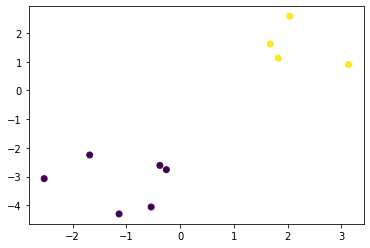

In [2]:
#toy data set
np.random.seed(1)
x_test = np.random.randn(6,2) - 2
x_test = np.vstack((x_test, np.random.randn(4,2) + 2))
y_test = np.array([-1 if x < 6 else 1 for x in range(10)])

#hyper paramethers
lambd_test = 1
rho_test = 0.1
tol_test = 1e-3
max_iter = 100

# # look linear separable data
x = x_test[:,0]
y = x_test[:,1]
t = np.linspace(x.min(), x.max())

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, c=y_test)
plt.show()


In [62]:
x_test

array([[-0.37565464, -2.61175641],
       [-2.52817175, -3.07296862],
       [-1.13459237, -4.3015387 ],
       [-0.25518824, -2.7612069 ],
       [-1.6809609 , -2.24937038],
       [-0.53789206, -4.06014071],
       [ 1.6775828 ,  1.61594565],
       [ 3.13376944,  0.90010873],
       [ 1.82757179,  1.12214158],
       [ 2.04221375,  2.58281521]])

In [64]:
y_test

array([-1, -1, -1, -1, -1, -1,  1,  1,  1,  1])

SVM
---

Veamos con el toy data que el svm está funcionando correctamente


Reached optimum at k = 5


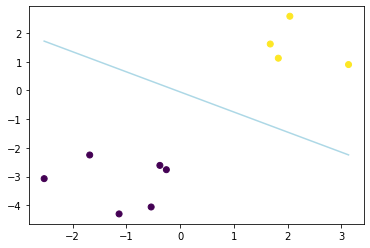

In [3]:
# test SVM Gradient (is ok)
th_ans, th0_ans, k_ans = svm_gradient(x_test, y_test, rho_test, lambd_test, tol_test, max_iter)

# # look data and SVM
t = np.linspace(x.min(), x.max())

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, c=y_test)
ax.plot(t, -(th_ans[k_ans][0] * t + th0_ans[k_ans]) / th_ans[k_ans][1], color='lightblue')
plt.show()


SVM estocástico
---

Veamos con el toy data que el svm estocástico está funcionando correctamente. Pondremos una semilla para que el índice estocástico sea siempre el mismo.

Reached optimum at k = 29


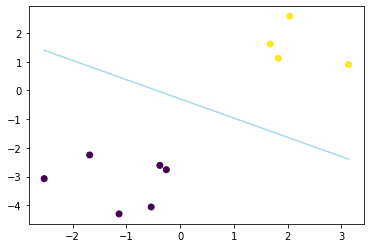

In [4]:
# test SVM Stochastic Gradient (is ok)
th_ans, th0_ans, k_ans = svm_sgd(x_test, y_test, rho_test, lambd_test, tol_test, max_iter)

# # look data and SVM
t = np.linspace(x.min(), x.max())

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, c=y_test)
ax.plot(t, -(th_ans[k_ans][0] * t + th0_ans[k_ans]) / th_ans[k_ans][1], color='lightblue')
plt.show()


# Datos iris

In [8]:
iris = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
urlretrieve(iris)
df = pd.read_csv(iris, sep=',')
columnas = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
df.columns = columnas
y=df["class"]
y=DataFrame([1 if i=="Iris-setosa" else -1 for i in y], columns=['class'])
df["class"]=y

In [15]:
def split_data(df, k):
    dataset_split = []
    aux = df.values.tolist()
    fold_size = int(len(df)/k)
    for i in range (k): 
        fold=[]
        while len(fold)<fold_size : 
            index = randrange(len(aux))
            fold.append(aux.pop(index))            
        dataset_split.append(fold)
    return dataset_split                  

In [5]:
def test_train(split_data, i):   
    test = []
    aux = list(split_data)    
    test.append(aux.pop(i))
    train = np.array(aux[0])
    j = 1
    while j<len(aux): 
        a = np.array(aux[j])
        train= np.vstack((a,train)) 
        j=j+1
    test=np.array(test[0])
    return (test,train)

In [6]:
def cross_validation(split_data, attributes, rho, l, tol_test, max_iter):    
    kfold_error = []   
    k=len(split_data)
    for i in range (k):
        #split data into test and train
        test, train = test_train(split_data, i)
        test = DataFrame (test,columns = attributes)    
        train= DataFrame (test,columns = attributes) 
        
        #split data into dependent and independent variables
        x_test = np.asarray(test.filter(attributes[0:len(attributes)-1], axis = 1))
        y_test = np.asarray(test[attributes[-1]]) 
        x_train = np.asarray(train.filter(attributes[0:len(attributes)-1], axis = 1))
        y_train = np.asarray(train[attributes[-1]]) 
        
        #training
        th, th0, k_ans = svm_gradient(x_train, y_train, rho, l, tol_test, max_iter)       
        
        #test_error
        th = th[-1]
        th0 = th0[-1]
        n = len(x_test)
        test_error = 0
        for j in range (n):
            test_error = test_error + abs(loss_01(th, th0, x_test[j], y_test[j]))    
        kfold_error.append(test_error/n)
        
        
    kfold_error=sum(kfold_error)/k
        
    return kfold_error 
        

In [7]:
def lambda_optima(df, k, attributes, rho, lambdas, tol_test, max_iter):
    split_data = split(df, k)
    lamb_error = []    
    for l in lambdas: 
        lamb_error.append(cross_validation(split_data, attributes, rho, l, tol_test, max_iter)) 
    minimo = lambdas[lamb_error.index(min(lamb_error))]             
    return(minimo, min(lamb_error))     

## Prueba
Para clasificar usaremos 2 algoritmos: el Perceptrón y Descenso por gradiente MVS.

### Descenso por gradiente MVS
Primero, obtendremos la lambda óptima usando el algoritmo de Descenso por gradiente MVS. Para esto, se correrán varios experimentos con validación cruzada. 

In [20]:
lambdas=[0.1, .2, .3]
k=5
rho_test = 0.1
tol_test = 1e-3
max_iter = 100
attributes=["petal_length", "petal_width", "class"]
df=df.filter(attributes, axis=1)

lambda_opt, error_lambda=lambda_optima(df, k, attributes, rho_test, lambdas, tol_test, max_iter)


Reached optimum at k = 7
Reached optimum at k = 14
Reached optimum at k = 18
Reached optimum at k = 4
Reached optimum at k = 2
Reached optimum at k = 6
Reached optimum at k = 19
Reached optimum at k = 10
Reached optimum at k = 50
Reached optimum at k = 75
Reached optimum at k = 6
Reached optimum at k = 13
Reached optimum at k = 7
Reached optimum at k = 35
Reached optimum at k = 76


In [21]:
lambda_opt

0.3

In [22]:
error_lambda

0.4068965517241379